# Data Analysis Interview Challenge
This is your chance to wow us with creative and rigorous solutions! Please include your code at the end of your submission, or in a separate file. We also accept incomplete solutions.

### Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [306]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import datetime, timedelta
%matplotlib inline
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load sklearn utilities
import sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, \
roc_auc_score, roc_curve, precision_recall_curve, auc, brier_score_loss, mean_squared_error, r2_score
from sklearn.calibration import calibration_curve

# Load classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()
import warnings
warnings.filterwarnings('ignore')

In [88]:
!ls

Take_Home_Challenge_1.ipynb         ultimate_data_challenge.json
logins.json                         ultimate_data_science_challenge.pdf


In [131]:
df_logins = pd.read_json('logins.json')

In [132]:
# check the type
type(df_logins['login_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [133]:
df_logins.shape

(93142, 1)

In [134]:
df_logins.set_index('login_time', inplace=True)

In [135]:
df_logins['count']=1

In [136]:
df_logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [137]:
# Aggregate these login counts based on 15min time intervals
df_15min = df_logins.resample('15T').sum()

<AxesSubplot:xlabel='login_time'>

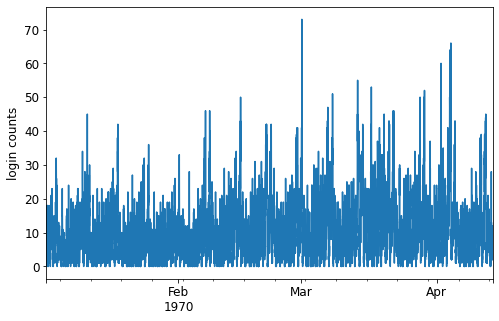

In [160]:
plt.rcParams.update({'font.size': 12})
df_15min['count'].plot(figsize=(8,5))
_=plt.ylabel('login counts')
_=plt.xlabel('')
_=plt.show()

In [139]:
df_15min.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Next, we look into more detail for month, day, hour in a day to see the pattern of the count over time

In [140]:
df_logins['time'] = pd.to_datetime(df_logins.index)

In [170]:
df_logins['day']= df_logins['time'].dt.day
df_logins['month']=df_logins['time'].dt.month
df_logins['hour']= df_logins['time'].dt.hour
df_logins['week']= df_logins['time'].dt.week
df_logins['weekday']= df_logins['time'].dt.weekday
df_logins['min']= df_logins['time'].dt.minute

<ipython-input-170-bdaf484fb227>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_logins['week']= df_logins['time'].dt.week


In [171]:
df_logins.head()

,count,time,day,hour,week,weekday,min,month
login_time,,,,,,,,
1970-01-01 20:13:18,1,1970-01-01 20:13:18,1,20,1,3,13,1
1970-01-01 20:16:10,1,1970-01-01 20:16:10,1,20,1,3,16,1
1970-01-01 20:16:37,1,1970-01-01 20:16:37,1,20,1,3,16,1
1970-01-01 20:16:36,1,1970-01-01 20:16:36,1,20,1,3,16,1
1970-01-01 20:26:21,1,1970-01-01 20:26:21,1,20,1,3,26,1


In [174]:
df_logins.month.unique()

array([1, 2, 3, 4])

<AxesSubplot:xlabel='hour'>

Text(0.5, 0, 'Hours')

Text(0, 0.5, 'Number of logins')

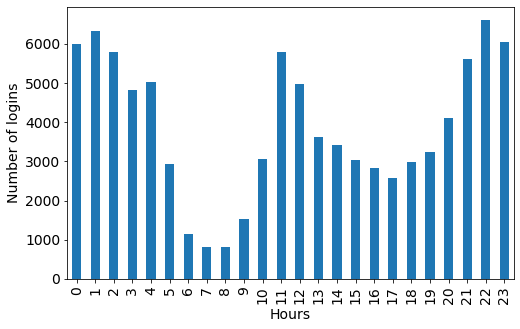

In [168]:
# login vs hours in a day
plt.rcParams.update({'font.size': 14})
(df_logins.groupby('hour')['count'].sum()).plot(kind='bar', figsize=(8,5))
plt.xlabel("Hours")
plt.ylabel("Number of logins")
plt.show()


We can see 6-9 am has the lowest login number. 10pm has the highest login number. There are high traffic between 10pm and 2am.

<AxesSubplot:xlabel='weekday'>

Text(0.5, 0, '')

Text(0, 0.5, 'Number of logins')

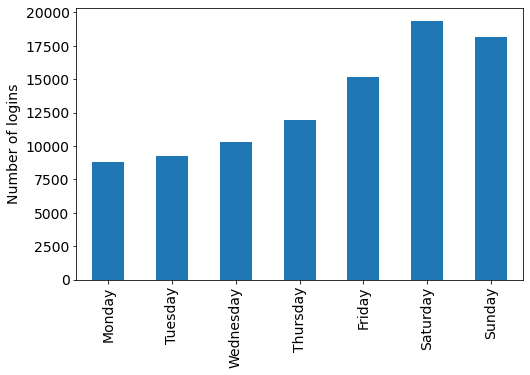

In [169]:
# login vs hours in a day
plt.rcParams.update({'font.size': 14})
(df_logins.groupby('weekday')['count'].sum()).plot(kind='bar', figsize=(8,5))
plt.xlabel("")
plt.ylabel("Number of logins")
_=plt.xticks(range(7),[calendar.day_name[d] for d in range(7)])
plt.show()


Weekend has the highest login traffic

Summary:
- Weekend is the most active times for logins
- There is high login traffic between 10pm and 2am. 
- The login has the lowest traffic between 6-8am.
- The login traffic has another peak at 11am-12pm
- The login traffic significantly decreases between 11am and 5pm.

### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


1. There are two metrics can be considered to tackle this problem.
- **Company revenue**:  this can be measured by the total company's profit.
- **Consumer riderability**: this can be measured by either WebAPP that is used for the service or payment transaction received from the consumer. We can also add consumer survey to see consumer's satisfaction for the survice, and how it impacts on the riderability.

A/B test can be used to evaluated the above two metrics before and after the experiments.

2. 
- I would design the experiment to two groups (control group: without reimbursing toll cost, test group: with reimbursing toll cost). These two groups will be randomly selected with the same numbers of driver partiners. We can first conduct the experiment for 1 months and perform A/B test to see the outcome.
- The hypothesis test will be conduct to verify if the toll cost reimbustment make a significant difference in terms of company revenue and consumer riderability. Specifically, we can measure the total company profit per day or the mean value of riders per day as metrics, and perform hypothesis test to see if the difference is statistically sifnificant with and without toll cost reimbustment.
- If the A/B test shows it is no difference, we can make a suggestion to stop the reimbusment program. However, even the test suggest there is a significant difference, we should evaluate how much profit we can gain and share this finding with the decision makers to make the final decision.  




### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [186]:
df_data = pd.read_json('ultimate_data_challenge.json')

In [187]:
df_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [188]:
df_data['signup_date']=pd.to_datetime(df_data['signup_date'])
df_data['last_trip_date']=pd.to_datetime(df_data['last_trip_date'])

In [190]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [192]:
# look at statistics
df_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [194]:
# check NaN
df_data.isnull().sum()/len(df_data)*100

city                       0.000
trips_in_first_30_days     0.000
signup_date                0.000
avg_rating_of_driver      16.244
avg_surge                  0.000
last_trip_date             0.000
phone                      0.792
surge_pct                  0.000
ultimate_black_user        0.000
weekday_pct                0.000
avg_dist                   0.000
avg_rating_by_driver       0.402
dtype: float64

There are missing value in 'avg_rating_of_driver','avg_rating_by_driver', and 'phone'. Since the missing value is still minority, we can simply drop the row of the missing value.

In [197]:
df_data.dropna(inplace=True)

#### Exploratory data analysis

<AxesSubplot:>

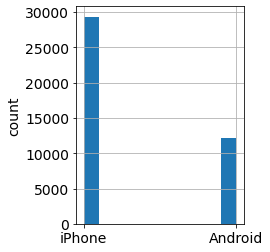

In [208]:
df_data['phone'].hist(figsize=(3,4))
_=plt.ylabel('count')
plt.show()

In [210]:
print(df_data['last_trip_date'].min())
print(df_data['last_trip_date'].max())


2014-01-01 00:00:00
2014-07-01 00:00:00


Since we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days, we label 'last_trip_date' after 2014-06-01 as 'active'(1) and before 2014-05-31 as 'inactive'(0). 

In [211]:
df_data['labels'] =np.where(df_data['last_trip_date']>='2014-06-01', 1, 0)

In [212]:
df_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,labels
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Next, we can make boxplot to check the outliers

<AxesSubplot:xlabel='avg_rating_of_driver'>

<AxesSubplot:xlabel='avg_rating_of_driver'>

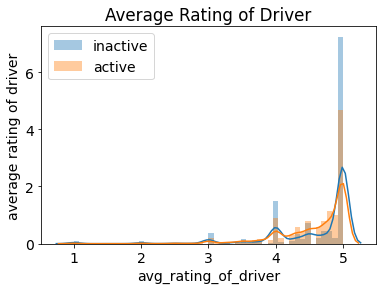

In [233]:
sns.distplot(df_data[df_data['labels']==0]["avg_rating_of_driver"], label='inactive')
sns.distplot(df_data[df_data['labels']==1]["avg_rating_of_driver"], label='active')
_=plt.legend()
_=plt.ylabel('count')
_=plt.ylabel('average rating of driver')
_=plt.title('Average Rating of Driver')
plt.show()

<AxesSubplot:xlabel='avg_rating_by_driver'>

<AxesSubplot:xlabel='avg_rating_by_driver'>

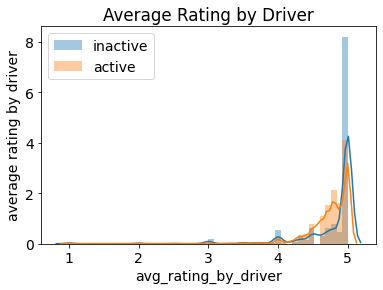

In [232]:
sns.distplot(df_data[df_data['labels']==0]["avg_rating_by_driver"], label='inactive')
sns.distplot(df_data[df_data['labels']==1]["avg_rating_by_driver"], label='active')
_=plt.legend()
_=plt.ylabel('count')
_=plt.ylabel('average rating by driver')
_=plt.title('Average Rating by Driver')
plt.show()

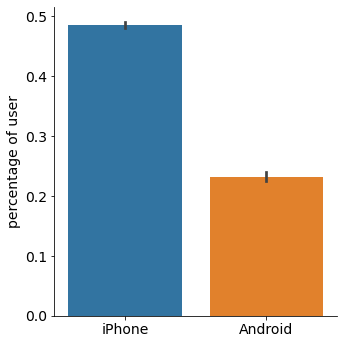

In [258]:
sns.catplot(y="labels", x="phone", kind="bar", data=df_data)
_=plt.ylabel('percentage of user')
_=plt.xlabel('')
plt.tight_layout()
plt.show()

More active users used iphone to signup the ride.

In [245]:
df_data['city'].value_counts()

Winterfell        19161
Astapor           13509
King's Landing     8775
Name: city, dtype: int64

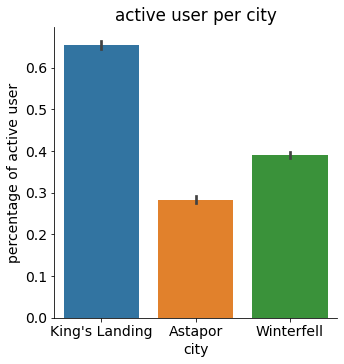

In [253]:
#df_data['labels'].hist(by=df_data['city'])

sns.catplot(y="labels", x="city", kind="bar", data=df_data)
_=plt.title('active user per city')
_=plt.ylabel('percentage of active user')
plt.show()

King's Landing has more active user

In [286]:
# need to one_hot_encode the categorical values of phone, city and user into numeric
df_ML = pd.get_dummies(df_data, columns=['city', 'phone','ultimate_black_user'])
df_ML.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,labels,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [287]:
df_ML['labels'].value_counts(normalize=True)

0    0.588973
1    0.411027
Name: labels, dtype: float64

The label is slightly unbalanced.

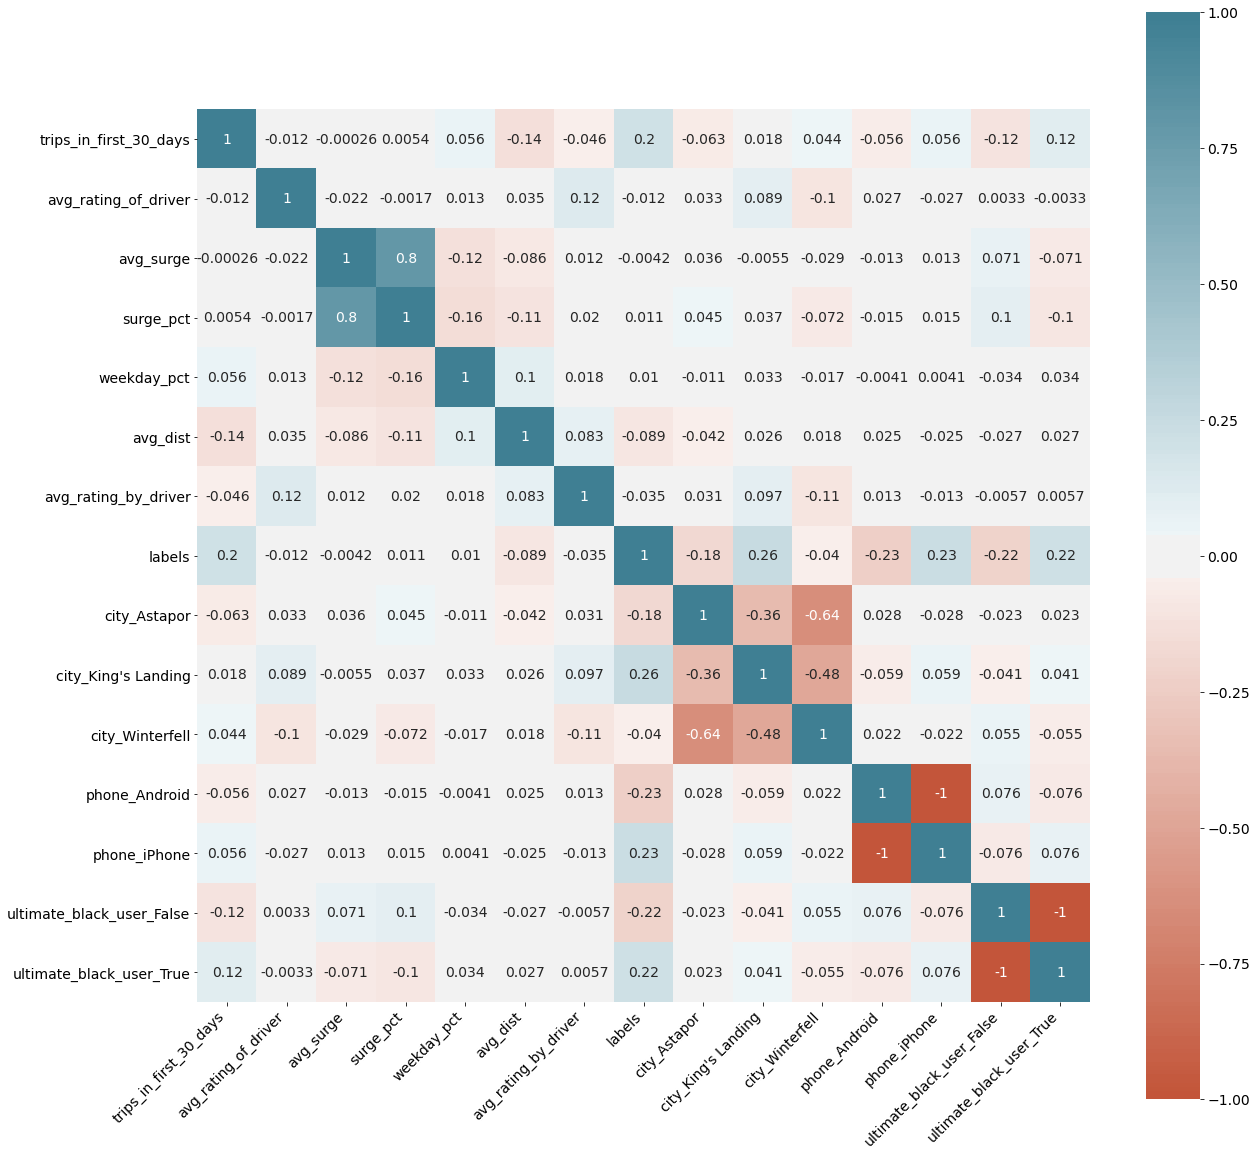

In [288]:
# heatmap

plt.figure(figsize=(20,20))

ax = sns.heatmap(
    df_ML.corr(), 
    vmin=-1, vmax=1, center=0,annot = True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

remove columns that are highly correlated

['ultimate_black_user_False', 'phone_Android','surge_pct', 'city_Winterfell']

In [289]:
ML_list = df_ML.columns.to_list()
ML_list.remove('last_trip_date')
ML_list.remove('signup_date')
ML_list.remove('surge_pct')
ML_list.remove('ultimate_black_user_False')
ML_list.remove('phone_Android')

In [290]:
ML_list

['trips_in_first_30_days',
 'avg_rating_of_driver',
 'avg_surge',
 'weekday_pct',
 'avg_dist',
 'avg_rating_by_driver',
 'labels',
 'city_Astapor',
 "city_King's Landing",
 'city_Winterfell',
 'phone_iPhone',
 'ultimate_black_user_True']

#### Machine Learning

In [291]:
X=df_ML[ML_list].drop(['labels'], axis=1)
y=df_ML['labels']

In [292]:
# train test split (20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [293]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(33156, 11) (33156,) (8289, 11) (8289,)


- upsampling using SMOTE

In [296]:
# load imbalanced-learn
from imblearn.over_sampling import SMOTE
start = time.time()
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
end= time.time()
print('It takes  ' + str(round((end-start), 1)) +' sec')

It takes  0.5 sec


In [299]:
# after oversampling
values, counts = np.unique(y_train_res, return_counts=True)
print(values, counts)

[0 1] [19587 19587]


In [298]:
# Standarization (after resampling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

- Help function to evaluate models

In [300]:
def evaluation_model(model, X_train, y_train, X_test, y_test):
    
    target_names = ['Non-Defaulted Loan','Defaulted Loan']
    y_pred = model.predict(X_test)
    
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, y_pred)))
    print("Classification Report: \n {}\n".format(classification_report(y_test, y_pred, \
                                                                            target_names=target_names)))
    print("Accuracy Score: {0:.4f}\n".format(accuracy_score(y_test,  y_pred)))    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    auc_test = cross_val_score(model, X_test, y_test, cv=cv, scoring='roc_auc')
    print("Stratified KFold Cross Validation:\n")
    print("--Training Set--")
    print("Mean AUC (cv): \t {0:.4f}".format(np.mean(auc_train)))
    print("SD AUC: \t\t {0:.4f}".format(np.std(auc_train)))
    print("--Test Set--")
    print("Mean AUC (cv): \t {0:.4f}".format(np.mean(auc_test)))
    print("SD AUC: \t\t {0:.4f}".format(np.std(auc_test)))

In [311]:
def auc_ruc_res(X_test, y_test, model):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1],
                                         pos_label=1)
    auc=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('AUC=',auc)
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', \
             label='AUC = %0.2f'% auc )
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [314]:
from sklearn.model_selection import GridSearchCV
def cv_best_parameters(model, param_grid):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    grid = GridSearchCV(model, param_grid,cv=cv, scoring='roc_auc')
    X=X_train_res
    y=y_train_res
    grid.fit(X,y)
    return grid.best_params_, grid.best_score_,grid.best_estimator_

1) Logestic Regression

In [304]:
model_LR = LogisticRegression()
model_LR.fit(X_train_res,y_train_res)

LogisticRegression()

In [307]:
scores_LR = evaluation_model(model_LR, X_train, y_train, X_test, y_test)

Confusion Matrix: 
 [[3523 1300]
 [1197 2269]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.75      0.73      0.74      4823
    Defaulted Loan       0.64      0.65      0.65      3466

          accuracy                           0.70      8289
         macro avg       0.69      0.69      0.69      8289
      weighted avg       0.70      0.70      0.70      8289


Accuracy Score: 0.6988

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.7597
SD AUC: 		 0.0070
--Test Set--
Mean AUC (cv): 	 0.7541
SD AUC: 		 0.0196


AUC= 0.7534280763493929


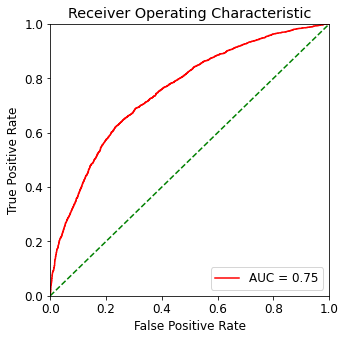

In [312]:
auc_ruc_res(X_test, y_test, model_LR)

2) Random Forest Classifier

In [315]:
model_RF = RandomForestClassifier(random_state=42)

n_estimators = [20,50,100,200]

param_grid = dict(n_estimators=n_estimators)

Best_params, Best_AUC, Best_classifier = cv_best_parameters(model_RF,param_grid)
print("Best AUC = "+ str(Best_AUC))
print(Best_classifier)

Best AUC = 0.8632798381053505
RandomForestClassifier(n_estimators=200, random_state=42)


In [318]:
model_RF_best = RandomForestClassifier(n_estimators=200, random_state=42)
model_RF_best.fit(X_train_res,y_train_res)

evaluation_model(model_RF_best, X_train_res, y_train_res, X_test, y_test)

RandomForestClassifier(n_estimators=200, random_state=42)

Confusion Matrix: 
 [[3701 1122]
 [1016 2450]]

Classification Report: 
                     precision    recall  f1-score   support

Non-Defaulted Loan       0.78      0.77      0.78      4823
    Defaulted Loan       0.69      0.71      0.70      3466

          accuracy                           0.74      8289
         macro avg       0.74      0.74      0.74      8289
      weighted avg       0.74      0.74      0.74      8289


Accuracy Score: 0.7421

Stratified KFold Cross Validation:

--Training Set--
Mean AUC (cv): 	 0.8633
SD AUC: 		 0.0049
--Test Set--
Mean AUC (cv): 	 0.8120
SD AUC: 		 0.0219


AUC= 0.8153286467911559


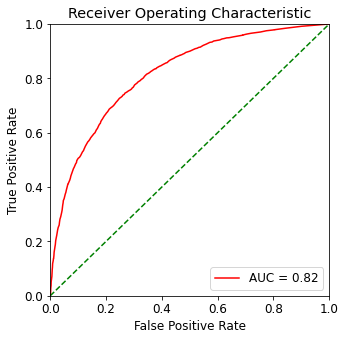

In [319]:
auc_ruc_res(X_test, y_test, model_RF_best)

- Feature Importance

<AxesSubplot:>

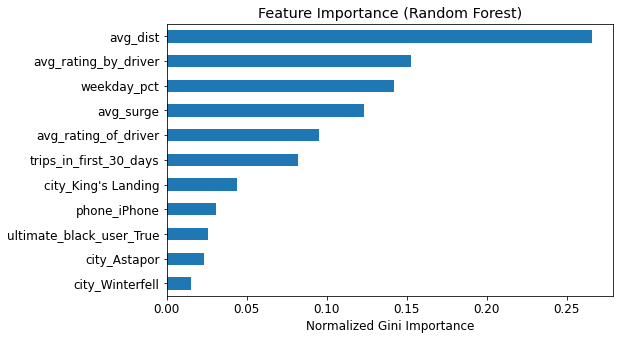

In [325]:
plt.rcParams.update({'font.size': 12})
_=plt.figure(figsize=(8,5))
feat_importances = pd.Series(model_RF_best.feature_importances_, \
                             index=X.columns)
feat_importances.nlargest(12).sort_values(ascending=True).plot(kind='barh')
_=plt.title('Feature Importance (Random Forest)')
_=plt.xlabel('Normalized Gini Importance')
_=plt.show()

In [345]:
#features correlated with retention
df_ML.corr().iloc[7].sort_values( ascending=False)

labels                       1.000000
city_King's Landing          0.255590
phone_iPhone                 0.233722
ultimate_black_user_True     0.217365
trips_in_first_30_days       0.198816
surge_pct                    0.011126
weekday_pct                  0.010423
avg_surge                   -0.004185
avg_rating_of_driver        -0.011829
avg_rating_by_driver        -0.034720
city_Winterfell             -0.039902
avg_dist                    -0.089498
city_Astapor                -0.180322
ultimate_black_user_False   -0.217365
phone_Android               -0.233722
Name: labels, dtype: float64

**Summary**
- Random Forest Classifier gives the best performance with AUC of 0.82.
- The model shows 74% accuracy to predict whether a user will be retained after 6 months of sign-up.
- According to feature importance from Random Forest Classifier, average distance. average rating by driver, and percentage of user's trip during weekday are three most important features.
- 'city_King's Landing', 'phone_iPhone', 'ultimate_black_user_True' are three features that postively correlated with labels.

**Conclusion/Recommendation**

Using the mechine learning model can predict the user rentetion and determine which important indicators have impact on the user rentention. Perhaps, Ultimate can provide 'Black' service promotions or incentices to users who use iPhone and/or live in King's Landing city.


### Data description

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday